<a href="https://www.kaggle.com/code/wuttipats/climate-sarima-forecasting?scriptVersionId=142258043" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created By**: Wuttipat S. <br>
**Created Date**: 2023-09-07 <br>
**Status**: <span style="color:green">Completed</span>

# About Notebook
This notebook aims to teach how to forecast the mean temperature of a climate change dataset using time series analysis with the **SARIMA** model. The SARIMA parameters will be determined using the `pmdarima.auto_arima` library. We will walk through the methodologies and steps to ultimately predict the future mean temperature.

# About Dataset

1. The dataset contains daily climate measurements for Delhi.
1. The train and test datasets have already been split.
1. The data consists of the following columns:
    - date
    - mean temperature
    - humidity
    - wind speed
    - mean pressure
1. In this notebook, we will only focus on forecasting the **mean temperature**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00


# 1. Data Loading and Preliminary Analysis
Before we proceed with the time series analysis, let's load and inspect the dataset first. Don't forget to set the dataframe index to a DateTime index. Essentially, the DateTime index is the foundation for working with time series data.

In [3]:
import pandas as pd

# Load the training dataset
train_data = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')

# Convert the date column to a datetime object and set it as the index
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)

train_data.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
# Load the test dataset
test_data = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

# Convert the date column to a datetime object and set it as the index for the test data
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)

test_data.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


For the SARIMA model, we need to decide which variable we want to forecast. A common choice for time series analysis in climate change data is temperature since it's easier for beginners to interpret.

Before we dive into the SARIMA model, let's visualize the training data for `train_data['meantemp']` to get a better understanding of its trend and seasonality.

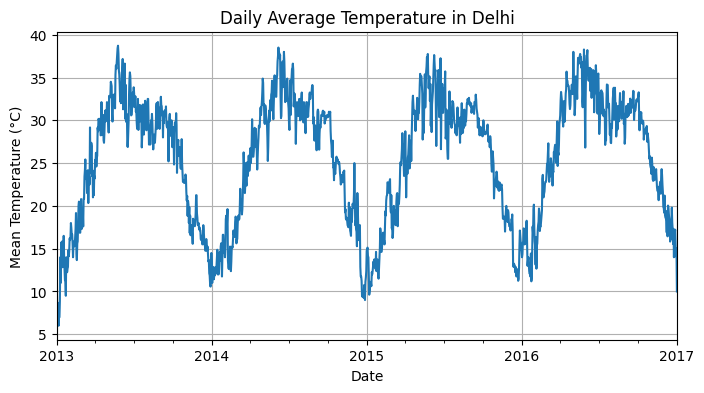

In [5]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')


# Plot the data
plt.figure(figsize=(8, 4))
train_data['meantemp'].plot(title='Daily Average Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.show()

We can see the mean temperature is significantly highest and lowest at the same time every year. This plot suggests that the mean temperature has annual seasonality. Therefore, **aggregating** them to *monthly* figures can make it easier to discern overall patterns or trends, since daily fluctuations contain noise.

In [6]:
# Resample the train data to a monthly frequency and take the average of each month
monthly_train_data = train_data['meantemp'].resample('M').mean()


# Resample the test data to a monthly frequency and take the average of each month
monthly_test_data = test_data['meantemp'].resample('M').mean()

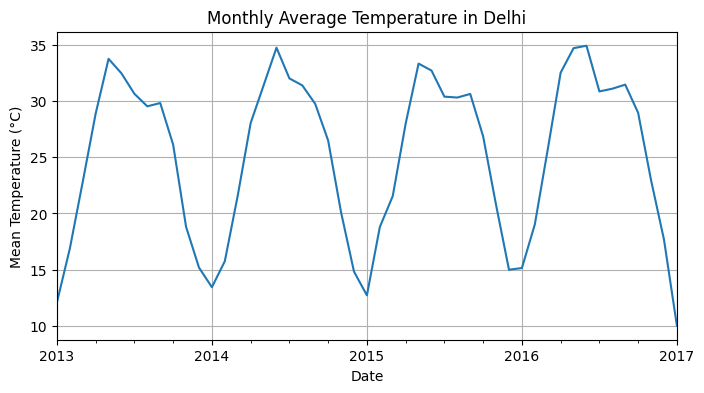

In [7]:
# Plot the resampled data
plt.figure(figsize=(8, 4))
monthly_train_data.plot(title='Monthly Average Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.show()


# 2. Time Series Decomposition
The plot shows the monthly average temperature in Delhi over the years. We can observe a clearer seasonality than the daily plot. Now, we'll **decompose** this time series to further analyze its trend, seasonality, and residuals. This will help us understand the underlying patterns in the data before fitting a SARIMA model. The time series decomposition provides the following insights:

- **Trend**: Represents the long-term movement in the data.
- **Seasonal**: Captures the regular pattern in the data that repeats over time.
- **Residual**: Represents the noise or irregular component left after extracting the trend and seasonal components.







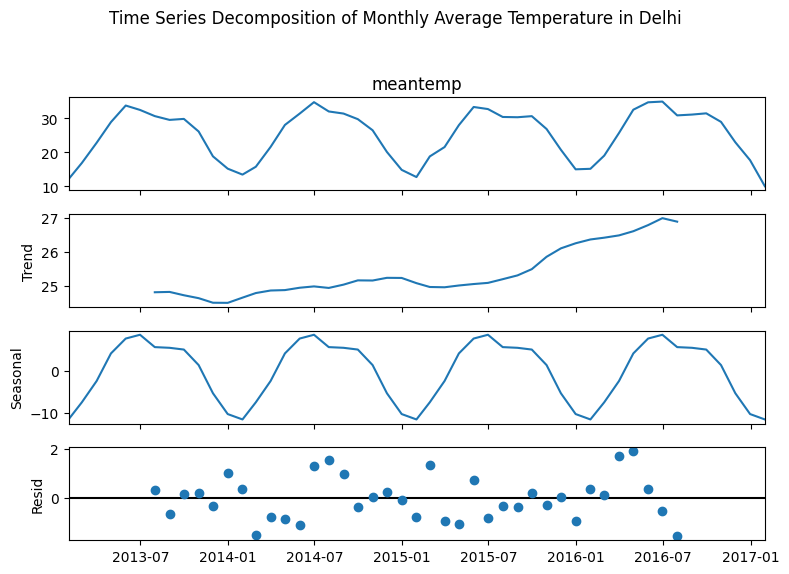

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthly_train_data, model='additive')

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.suptitle('Time Series Decomposition of Monthly Average Temperature in Delhi')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 3. Stationarity Check
We'll use the Augmented Dickey-Fuller test to check if the `meantemp` time sereis is **stationary**.
<br><br><br>
The **Augmented Dickey-Fuller (ADF)** test is a statistical procedure used to test whether a given time series is stationary or not. Here's why perform the ADF test is crucial:
1. Many time series models, like ARIMA, assume the train data is stationary.
1. The ADF testing can guide how much differecing might be needed.
1. Models trained on stationary data trend to be more reliable than those trained on non-stationary data.

In [9]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
result = adfuller(monthly_train_data)

# Displaying the test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'Results: {result}')
print()

print(f'ADF Statistic: {adf_statistic}')
print(f'p-values: {p_value}')
print('Critical Values:')
print(f'  1%: {critical_values["1%"]}')
print(f'  5%: {critical_values["5%"]}')
print(f'  10%: {critical_values["10%"]}')

Results: (-1.0462204206798933, 0.7360356050589151, 10, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 154.258413240739)

ADF Statistic: -1.0462204206798933
p-values: 0.7360356050589151
Critical Values:
  1%: -3.6155091011809297
  5%: -2.941262357486514
  10%: -2.6091995013850418


The results object is a tuple. The zeroth element is the test statistic, in this case it is -1.04. The more negative this number is, the more likely that the data is stationary. The next item in the results tuple, is the test p-value. Here it's 0.73. The p-value is much higher than 0.05, **we failed to reject the null hypothesis and assume our time series is non-stationary.** The last item in the tuple is a dictionary. This stores the critical values of the test statistic which equate to different p-values. In this case, if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.94.

# 4. Differencing
To make the series stationary, when there's annual seasonality in monthly data, the seasonality spans 12 months. To remove the annual seasonality, we can take the difference with a lag of 12 months by applying `.diff(periods=12).dropna()`.

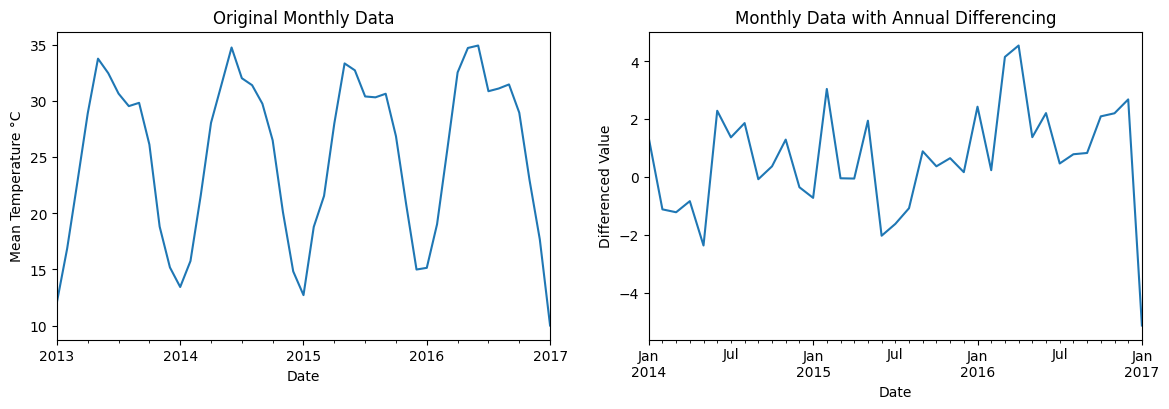

In [10]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

# Original Data
monthly_train_data.plot(ax=ax[0])
ax[0].set_title('Original Monthly Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Temperature °C')

# Differenced Data
monthly_train_data.diff(periods=12).dropna().plot(ax=ax[1])
ax[1].set_title('Monthly Data with Annual Differencing')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Differenced Value')
plt.show()

The annual differencing plot shows the differences in mean temperature from one month to the same month in the next year. The seasonal pattern seems to have been eliminated.

<br><br><br>

Next, let's apply the ADF test again to the differenced data.

In [11]:
# Augmented Dickey-Fuller test
result = adfuller(monthly_train_data.diff().dropna())


# Displaying the test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-values: {p_value}')
print('Critical Values:')
print(f'  1%: {critical_values["1%"]}')
print(f'  5%: {critical_values["5%"]}')
print(f'  10%: {critical_values["10%"]}')


ADF Statistic: -7.275868440106254
p-values: 1.545072980597148e-10
Critical Values:
  1%: -3.6155091011809297
  5%: -2.941262357486514
  10%: -2.6091995013850418


The ADF statistic is now much lower the critical value, and p-value is virtually zero. This suggest that the differenced series **is stationary**.
<br><br><br>

> <p style="color: red;">Please note, in this notebook we'll use pmdarima to automatically select the best SARIMA model. One of its features is the ability to determine the order of differencing d automatically. Therefore, we won't use the differenced data to feed the model. The ADF test mentioned earlier is to provide a foundation for checking the stationarity of the time series data.</p>

# 5. ACF and PACF plots
To determine the best parameters, we'll use the **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots, along with the grid search approach, `auto_arima`. Let's begin with the ACF and PACF plots.
<br><br>

To interpret the ACF and PACF plots, we can look for the following patterns:

- A sharp cutoff in the ACF plot at a particular lag suggests that a time series model with a corresponding number of lags would be a good fit.
- A slowly decaying ACF plot may indicate the presence of a trend in the data.
- A slowly decaying PACF plot may indicate the presence of seasonality in the data.
- A sharp cutoff in the PACF plot at a particular lag may indicate the presence of a seasonal pattern in the data.

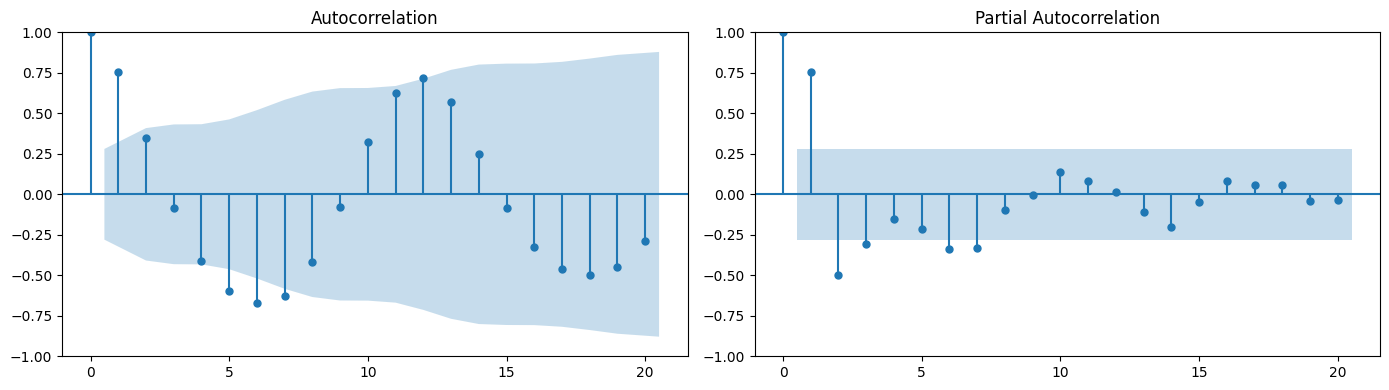

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Plot ACF
plot_acf(monthly_train_data, lags=20, ax=ax[0])

# Plot PACF
plot_pacf(monthly_train_data, lags=20, ax=ax[1])

plt.tight_layout()
plt.show()


The ACF and PACF plots can previde initial estimates for the order of AR an MA, which is *p, q, P, Q, s* in the SARIMA model.
1. ACF: The plot shows significant lags at 1, 12. This suggest seasonality seems to be annual, so *s*=12. While slowly decay indicate the trend in data.
1. PACF: The sharp cutoff occured in the PACF plot, this indicate the seasonal pattern in our data.

# 6. SARIMA Model Building with Automated Model Selection

With this understanding, we can move on to the SARIMA model-building process. The SARIMA model is characterized by several parameters: p,d,q,P,D,Q,s .
- ***p*** - (non-seasonal AR order)
- ***d*** - (non-seasonal differencing order)
- ***q*** - (non-seasonal MA order)
- ***P*** - (seasonal AR order)
- ***D*** - (seasonal differencing order)
- ***Q*** - (seasonal MA order)
- ***s*** - (seasonal period length)



Now we'll have to find the best SARIMA model. Fortunately `pmdarima` package is a powerful tool, that *automatically discover the optimal order for an ARIMA model.*

In [13]:
# Import pmdarima as pm
import pmdarima as pm

# Create model for SARIMAX(p,1,q)(P,1,Q)12
best_model = pm.auto_arima(monthly_train_data,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      stepwise=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=149.017, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=154.686, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=147.633, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=156.606, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=155.971, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=147.522, Time=0.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=149.432, Time=0.82 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=147.497, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=149.432, Time=0.87 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=147.449, Time=0.53 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=148.932, Time=0.35 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=14

The optimal parameters for the SARIMA model, based on the **lowest AIC value** are:
- Non-seasonal parameters (p,d,q) = (0,0,1)
- Seasonal parameters:(P,D,Q,s) = (0,1,2,12)
- AIC values:  147.131 
<br>
<br>

> **AIC - Akaike information criterion**
>    - Lower AIC indicates a better model
>    - AIC likes to choose simple models with lower order
>
> *soure: datacamp*


# 7. Model Evaluation

With this model, let's inspect the model's diagnostic plots. Model diagnostics are essential in validating the accuracy and reliability of time series models. This plot introduced tools to evualte the residuals, which are the differences between a model's predictions and actual values. Through various plots and statictis, such as :

| Plot                          | Good fit                                                                                   |
|-------------------------------|-------------------------------------------------------------------------------------------|
| Standardized residual         | There are no obvious patterns in the residuals                                            |
| Histogram plus kde estimate   | The KDE curve should be very similar to the normal distribution                           |
| Normal Q-Q                    | Most of the data points should lie on the straight line                                   |
| Correlogram                   | 95% of correlations for lag greater than zero should not be significant                    |
source: DataCamp

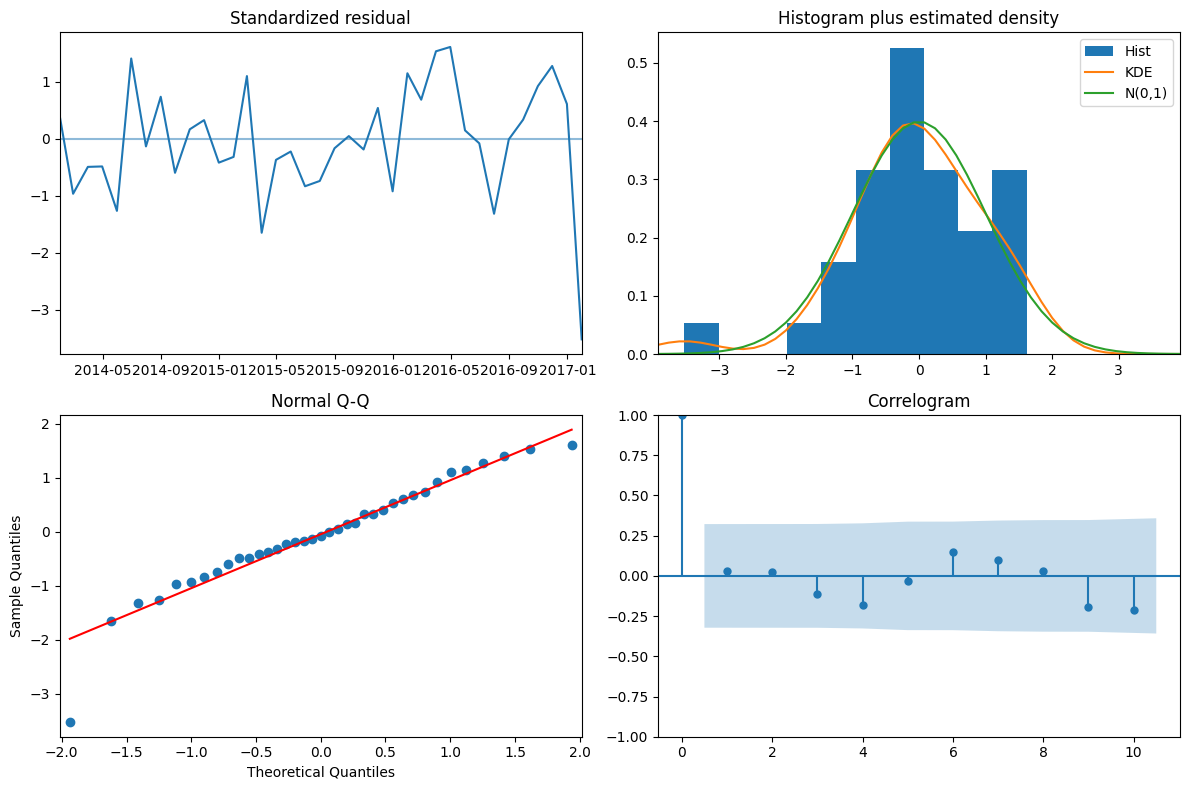

In [14]:
# Plot the model diagnostics
fig = best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()


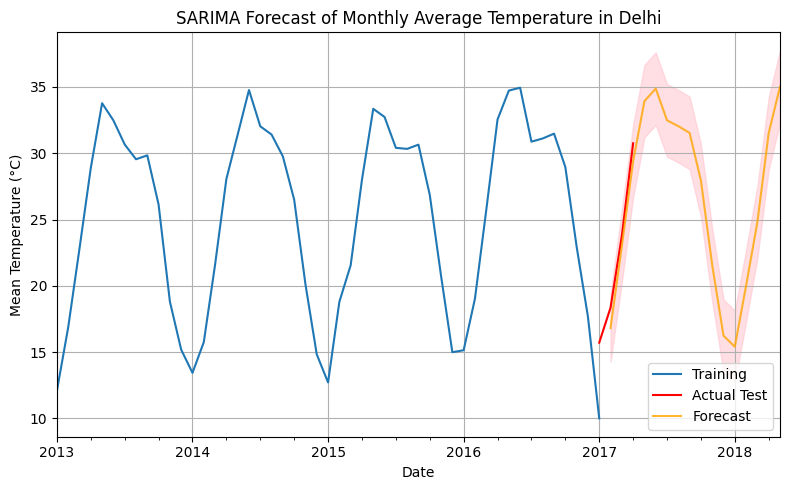

In [15]:
# Forecast for the duration of the test dataset
forecast_values, conf_int = best_model.predict(n_periods=len(monthly_test_data)+12, return_conf_int=True)

# Create a date index for forecast_values
forecast_index = forecast_values.index

# Convert forecast_values and conf_int to pandas series with the correct date index
forecast_series = pd.Series(forecast_values, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

# Plot the actual vs predicted values
plt.figure(figsize=(8, 5))
monthly_train_data.plot(label='Training', legend=True)
monthly_test_data.plot(label='Actual Test', legend=True, color='red')
forecast_series.plot(label='Forecast', legend=True, color='orange', alpha=0.8)
plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.5)
plt.title('SARIMA Forecast of Monthly Average Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

The <span style="color: orange; font-weight: bold;">orange</span> line in the plot represent the SARIMA model's forecast for the monthly average temperature in Delhi, while the <span style="color: pink; font-weight: bold;">pink</span> shaded area shows the confidence interval for the forecast.

From the plot, we can see the forecast closely follows the actual test values, indicating that the SARIMA model has done a decent job.

<br><br><br>

To qualtitatively evalute the model's performance, we will calculate the **Mean Absolute Error (MAE)** between the forecasted and actual values.

In [16]:
from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error
mae = mean_absolute_error(monthly_test_data, forecast_values[:len(monthly_test_data)])

mae


3.641516545102166

The Mean Absolute Error (MAE) between the forecasted and actual values for the test dataset is approximately 3.64 °C. This means on average our forecasts were about 3.64 °C away from the actual monthly average teamperatures.

# Summary
- The SARIMA model has provided a reasonable forecast for the monthly average temperatures in Delhi for the test data duration and beyond.
- The confidence intervals provide a range of plausible values for the forecasts, indicating the certainty associated with the predictions.